In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.functional import softmax
from torchvision import datasets, transforms

import os
import pandas as pd
from numpy import linalg as LA
from tqdm import tqdm
import time
from torch.utils import data
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import eigh
from scipy.linalg import eig

from scipy.stats import multivariate_normal as normalpdf
from scipy.stats import multinomial as multinomial
from numpy.random import multivariate_normal as sample_normal
from numpy.random import binomial as binomial
import random

import collections

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Operator learning has received considerable attention in the past a few years. Different from the classical learning, operator learning learns an operator which maps a function space to another function space, i.e., the network input and output are both functions.

Let $V$, $U$ be two function spaces, and $G:V\rightarrow U$ be an operator. Specifically, $G(u)(\cdot)\in U$ for any $u\in V$. Moreover, we will call $u(y)$ input function and denote its domain as $K_1$; $G(u)(\cdot)$ is the output function (corresponding to $u$). We want to construct a neural network $G_{\theta}$ to approximate $G()$, i.e.,

\begin{align}
G(u)(x)\approx G_{\theta}(u)(x),
\end{align}
for all $u\in V$ and $x\in K_2$, where $K_2$ is the domain of the output function.

Here we list some great works about operator learning:
1. T. Chen and H. Chen. Universal approximation to nonlinear operators by neural networks with arbitrary activation functions and its application to dynamical systems. IEEE Transactions on Neural Networks, 6(4):911–917, 1995.

The authors proposed and proved the universal approximation theory for the continuous operator.


2. L. Lu, P. Jin, G. Pang, Z. Zhang, and G. E. Karniadakis. Learning nonlinear operators via DeepONet based on the universal approximation theorem of operators. Nature Machine Intelligence, 3(3):218–229, 2021.

One calls the network in this masterpiece DeepONet or DON.

3. Z. Li, N. Kovachki, K. Azizzadenesheli, B. Liu, K. Bhattacharya, A. Stuart, and A. Anandkumar. Fourier neural operator for parametric partial differential equations. arXiv preprint arXiv:2010.08895, 2020.

One calls the network in this masterpiece FNO.

4. Z. Zhang, W. T. Leung and H. Schaeffer. BelNet: Basis enhanced learning, a mesh-free neural operator. arXiv preprint arXiv:2212.07336, 2022.



In this kernel, we will discuss the coding for BelNet: basis enhanced learning. It is a mesh free neural operator. We refer to https://arxiv.org/pdf/2212.07336.pdf.

One can follow the steps here to prepare data and write codes for other great operator learning networks such as DeepONet.

We consider the Viscous Burgers equation example, which is example 1 (Section 4.1) of the work: https://arxiv.org/pdf/2212.07336.pdf.
The PDE is 1D in space and time, and we want to learning the mapping from the initial condition (which is a function of $x$) to the solution at the terminal time (which is another function of $x$).

In [2]:
aa = 151
max_x = 2*np.pi
hh = max_x/(aa-1)


# load the data

# set_of_exact_solution: exact solutions. 
path = "../input/v-burgers-data/set_sol.npy"
set_of_exact_solution = np.load(path)
print("set_of_exact_solution", np.shape(set_of_exact_solution))

# After the transpose: the first dimension is the number of samples, the second dimension is the time, the last dimension is the space.
set_of_exact_solution = np.transpose(set_of_exact_solution, (0, -1, 1))
print("transpose set_of_exact_solution", np.shape(set_of_exact_solution))


print("--------------------------------------------------------------->>")


path = "../input/v-burgers-data/set_ic.npy"

# set_of_ff is the initial condition (solution at the t = 0), the first dimension is the the number of samples, the second dimension is the space
# Forget about the weird name, but set_of_ff is the set of input functions.

set_of_ff = np.load(path)
print("set_of_ff", np.shape(set_of_ff))
print("--------------------------------------------------------------->>")

total_nb_of_samples = len(set_of_exact_solution)
# # tpptr
nb_training_samples = 200
nb_testing_samples = total_nb_of_samples - nb_training_samples
print("--------------------------------------------------------------->>")
training_exact_solution = set_of_exact_solution[:nb_training_samples]
print("training_exact_solution", np.shape(training_exact_solution))


testing_exact_solution = set_of_exact_solution[nb_training_samples:]
print("testing_exact_solution", np.shape(testing_exact_solution))
print("--------------------------------------------------------------->>")
training_ff = set_of_ff[:nb_training_samples]
print("training_ff", np.shape(training_ff))
testing_ff = set_of_ff[nb_training_samples:]
print("testing_ff", np.shape(testing_ff))


path = "../input/v-burgers-data/save_time_coord.npy"
velocity = np.load(path)
print("velocity", np.shape(velocity))

vel_idx = [ii for ii in range(len(velocity))]
print("vel_idx", vel_idx)

set_of_exact_solution (2001, 151, 16)
transpose set_of_exact_solution (2001, 16, 151)
--------------------------------------------------------------->>
set_of_ff (2001, 151)
--------------------------------------------------------------->>
--------------------------------------------------------------->>
training_exact_solution (200, 16, 151)
testing_exact_solution (1801, 16, 151)
--------------------------------------------------------------->>
training_ff (200, 151)
testing_ff (1801, 151)
velocity (16,)
vel_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


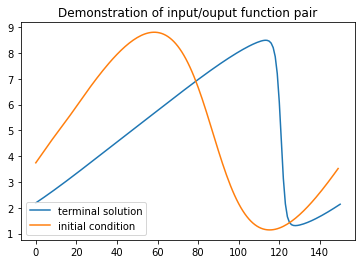

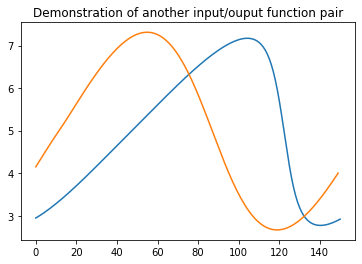

In [3]:
plt.plot(training_exact_solution[0, -1], label = "terminal solution")
plt.plot(training_ff[0, :-1], label = "initial condition")
plt.title("Demonstration of input/ouput function pair")
plt.legend()
plt.show()



plt.plot(training_exact_solution[-1, -1],  label = "terminal solution")
plt.plot(training_ff[-1, :-1], label = "initial condition")
plt.title("Demonstration of another input/ouput function pair")
plt.show()

The next cell loads sensors. Sensor, which are some points in the domain of the input function space, are used to sample the input function values.

BelNet is invariant to the input function discretization, or one can employ different sets of sensors (discretizations) for different input functions.



In [4]:
# for the rdm sensors version (use sensors to measure ic)

# set_of_coord_of_source: the coord of all samples' input function sensors
set_of_coord_of_source = np.squeeze(np.load("../input/v-burgers-data/set_of_coord_of_source.npy"))
# set_of_source_value: the function (it is just initial condition) values at all samples' input function sensors
set_of_source_value = np.load("../input/v-burgers-data/set_of_source_value.npy")

print("set_of_coord_of_source", np.shape(set_of_coord_of_source))
print("set_of_source_value", np.shape(set_of_source_value))

load_set_of_training_coord_of_source = set_of_coord_of_source[:nb_training_samples]
load_set_of_training_source_value = set_of_source_value[:nb_training_samples]
print("load_set_of_training_coord_of_source", np.shape(load_set_of_training_coord_of_source))
print("load_set_of_training_source_value", np.shape(load_set_of_training_source_value))

load_set_of_testing_coord_of_source = set_of_coord_of_source[nb_training_samples:]
load_set_of_testing_source_value = set_of_source_value[nb_training_samples:]

print("load_set_of_testing_coord_of_source", np.shape(load_set_of_testing_coord_of_source))
print("load_set_of_testing_source_value", np.shape(load_set_of_testing_source_value))

print("--------------------------------------------------------------->>")
# # tppsrc
size_of_coarse = 2

# We sub-sample all sensors, and will use 25 sensors for each different samples.
set_of_training_coord_of_source1 = load_set_of_training_coord_of_source[:, 0::size_of_coarse, ]
print("set_of_training_coord_of_source1", np.shape(set_of_training_coord_of_source1))
set_of_training_coord_of_source = set_of_training_coord_of_source1

set_of_training_source_value = load_set_of_training_source_value[:, 0::size_of_coarse ]
print("set_of_training_coord_of_source", np.shape(set_of_training_coord_of_source))
print("set_of_training_source_value", np.shape(set_of_training_source_value))

print("--------------------------------------------------------------->>")

set_of_testing_coord_of_source1 = load_set_of_testing_coord_of_source[:, 0::size_of_coarse,]
print("set_of_testing_coord_of_source1", np.shape(set_of_testing_coord_of_source1))
set_of_testing_coord_of_source = set_of_testing_coord_of_source1

set_of_testing_source_value = load_set_of_testing_source_value[:, 0::size_of_coarse ]
print("set_of_testing_coord_of_source", np.shape(set_of_testing_coord_of_source))
print("set_of_testing_source_value", np.shape(set_of_testing_source_value))

set_of_coord_of_source (2001, 50)
set_of_source_value (2001, 50)
load_set_of_training_coord_of_source (200, 50)
load_set_of_training_source_value (200, 50)
load_set_of_testing_coord_of_source (1801, 50)
load_set_of_testing_source_value (1801, 50)
--------------------------------------------------------------->>
set_of_training_coord_of_source1 (200, 25)
set_of_training_coord_of_source (200, 25)
set_of_training_source_value (200, 25)
--------------------------------------------------------------->>
set_of_testing_coord_of_source1 (1801, 25)
set_of_testing_coord_of_source (1801, 25)
set_of_testing_source_value (1801, 25)


In the next cell, we demonstrate the sampled input function values (IC) by sensors and the exact input function.

We present two samples, but please note that the discretizations (sensors, the black dots) for these two samples are different.

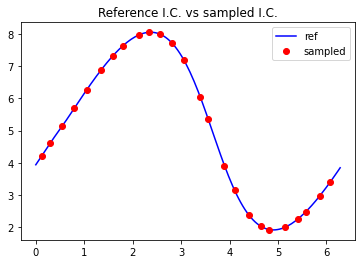

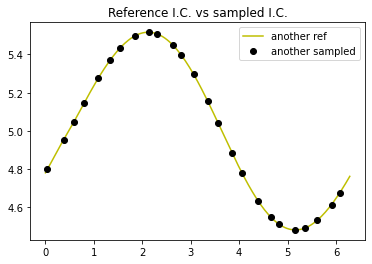

In [5]:
DX = max_x/(aa-1)
x = np.zeros(aa)

for i in range(0, aa):
    x[i] = i*DX

path = "../input/v-burgers-data/set_ic.npy"
set_ic = np.load(path)

which_sample_to_show = 10
which_sample_to_show2 = 100

plt.plot(x, set_ic[which_sample_to_show, :], "b-", label = "ref")
plt.plot(np.array(set_of_training_coord_of_source)[which_sample_to_show, :], np.array(set_of_training_source_value)[which_sample_to_show, :], "ro", label = "sampled")
plt.legend()
plt.title("Reference I.C. vs sampled I.C.")
plt.show()

plt.plot(x, set_ic[which_sample_to_show2, :], "y-", label = "another ref")
plt.plot(np.array(set_of_training_coord_of_source)[which_sample_to_show2, :], np.array(set_of_training_source_value)[which_sample_to_show2, :], "ko", label = "another sampled")
plt.legend()
plt.title("Reference I.C. vs sampled I.C.")
plt.show()

The next cell prepares the training data. Preparing the training and testing data may be the most difficult steps in operator learning. 

This step is roughly the same for all neural operator structures such as DeepONet (DON).

In general, the data preparation follows from the loss function of operator learning.

Suppose one has $N_u$ input functions in total, and denote i-th input function as $u_i$, its coresponding output function as $G(u_i)(\cdot)$.

Let us assume the output function $G(u_i)(\cdot)$ values are known at $\{x_k^i\}_{k = 1}^{N_i}$ and denote the the value at $x_k^i$ as $y_k^i$.

Here $x_k^i$ is the independent variable of the output function, it can be a vector (e.g., space + time).

We want to minimize the following loss function,

\begin{align}
\min_{\theta} \frac{1}{N_uN_i}\sum_{i = 1}^{N_u} \sum_{ k = 1}^{N_i}\|y_k^i - G_{\theta}(u_i)(x_k^i)\|^2_F,
\end{align}
where $\theta$ denotes all trainable parameters of the network $G_{theta}(\cdot)(\cdot)$.

In the next cell, nb_point_used_per_row is the $N_i$. We assume $x_k^i$ are the same for all samples. 

In [6]:
# This is the N_i, or number of solution values for each output function.
nb_point_used_per_row = 20

# the x coordinate for each output function
training_x_index = np.linspace(1, aa-1, nb_point_used_per_row, dtype = int)

print("training_x_index", training_x_index)

# this function returns: solutions (output functions) at some points 
# and the coord of these points.
# x_index are the row and col index of the these points
# which_velocity indicates the time (note that: the solution depends both on space and time).

def mesh_and_sol_value(sol, x_index, which_velocity):
    training_coord = []
    training_val = []
    
    for ii in range(len(x_index)):

        training_coord.append( [ (x_index[ii] )*hh, velocity[which_velocity]] )
        training_val.append(sol[which_velocity, x_index[ii] ])

    return training_coord, training_val

training_sol_coord = []
training_sol_value = []


# We do not use solutions at all time steps to train, so we select some time levels.
# train_vel is the candidate time indices for all solutions
train_vel = vel_idx[1::3]
print("train_vel", train_vel)

for ii in (range(len(training_exact_solution))):
    temp1 = []
    temp2 = []
    for jj in train_vel:

        ta, tb = mesh_and_sol_value(training_exact_solution[ii], training_x_index, jj)

        temp1.append(ta)
        temp2.append(tb)

    training_sol_coord.append(temp1)
    training_sol_value.append(temp2)

    
# Dimension 1: # of inout functions (IC)
# Dimension 2: # time steps
# Dimension 3: # space discretization points
# Dimension 4 (for) training_sol_coord: coordinate (space, time)
print("training_sol_coord", np.shape(training_sol_coord))
print("training_sol_value", np.shape(training_sol_value))
print("--------------------------------------------------------------->>")


# reshape
training_sol_coord = np.reshape(training_sol_coord, (len(training_sol_coord), -1, 2))
training_sol_value = np.reshape(training_sol_value, (len(training_sol_coord), -1))
print("reshape training_sol_coord", np.shape(training_sol_coord))
print("reshape training_sol_value", np.shape(training_sol_value))

training_x_index [  1   8  16  24  32  40  48  55  63  71  79  87  95 102 110 118 126 134
 142 150]
train_vel [1, 4, 7, 10, 13]
training_sol_coord (200, 5, 20, 2)
training_sol_value (200, 5, 20)
--------------------------------------------------------------->>
reshape training_sol_coord (200, 100, 2)
reshape training_sol_value (200, 100)


The next cell further reshape the training data and generate the Pytorch tensors for training.

In [7]:
# tppdim

dim_output_space_basis = 10

def training_in_output( nb_of_sample_observation, training1_sol_coord, training1_sol_value):
    training_node_input = []
    training_u_input = []
    training_dependent_input = []
    training_output = []

    for ii in range(len(set_of_training_source_value)):
        for jj in range(nb_of_sample_observation):
            training_u_input.append(set_of_training_source_value[ii])
            training_node_input.append(set_of_training_coord_of_source[ii])

            training_dependent_input.append(training1_sol_coord[ii][jj])

            training_output.append(training1_sol_value[ii][jj])
    
    training_dependent_input = np.expand_dims(training_dependent_input, axis = 1)
    print("training_node_input", np.shape(training_node_input))
    print("training_u_input", np.shape(training_u_input))
    print("training_output", np.shape(training_output))
    print("training_dependent_input", np.shape(training_dependent_input))
    
    print("--------------------------------------------------------------->>")

    torch_training_u_input = torch.tensor(np.expand_dims(training_u_input, axis = -1), dtype=torch.float32, device = device)
    torch_training_node_input = torch.tensor(np.expand_dims(training_node_input, axis = 1), dtype=torch.float32, device = device)
    torch_training_output = torch.tensor(np.expand_dims(training_output, axis = -1), dtype=torch.float32, device = device)
    torch_training_dependent_input = torch.tensor(training_dependent_input, dtype=torch.float32, device = device)
    
    print("torch_training_u_input", torch_training_u_input.size())
    print("torch_training_node_input", torch_training_node_input.size())
    print("torch_training_output", torch_training_output.size())
    print("torch_training_dependent_input", torch_training_dependent_input.size())

    return torch_training_u_input, torch_training_node_input, torch_training_output, torch_training_dependent_input

torch_training_u_input, torch_training_node_input, torch_training_output, torch_training_dependent_input = training_in_output(np.shape(training_sol_value)[1], training_sol_coord, training_sol_value)

training_node_input (20000, 25)
training_u_input (20000, 25)
training_output (20000,)
training_dependent_input (20000, 1, 2)
--------------------------------------------------------------->>
torch_training_u_input torch.Size([20000, 25, 1])
torch_training_node_input torch.Size([20000, 1, 25])
torch_training_output torch.Size([20000, 1])
torch_training_dependent_input torch.Size([20000, 1, 2])


The next block generate selects one sample for testing. This sample is only used to show the generalization loss decay during the training process.

We later will test on all samples with a dense mesh in space after the model is well trained.

In [8]:
which_sample_to_test = 0
testing_x_index = [ii for ii in range(aa+1)]

testing_x_index = np.arange(1, aa-1, 1, int)
print("testing_x_index", np.shape(testing_x_index))

# sample_id: whcih test sample to test
# indexy: y index of the solution mesh, generated before
# if demo is true, the dim of vectors will print, this is used to check
def testing_in_output(sample_id, indexx, demo ):
    
    testing_sol_coord = []
    testing_sol_value = []
    

    temp1, temp2 = mesh_and_sol_value(testing_exact_solution[sample_id], indexx, vel_idx[-1])
    testing_sol_coord.append(temp1)
    testing_sol_value.append(temp2)
    
    testing_sol_coord = np.squeeze(testing_sol_coord )
    testing_sol_value = np.squeeze(testing_sol_value )


    testing_node_input = []
    testing_u_input = []

    testing_u_input.append(set_of_testing_source_value[sample_id])
    # need to lift the dimension,since we test the same source at the same location for all points in the solution domain
    testing_u_input = np.repeat(testing_u_input, len(testing_sol_value), axis = 0)

    testing_node_input.append(set_of_testing_coord_of_source[sample_id])
    testing_node_input = np.repeat(testing_node_input, len(testing_sol_value), axis = 0)

    testing_dependent_input = np.expand_dims(testing_sol_coord, axis = 1)

    
    testing_output = np.expand_dims(testing_sol_value, axis = 1)

    
    torch1_testing_u_input = torch.tensor(np.expand_dims(testing_u_input, axis = -1), dtype=torch.float32, device = device)
    torch1_testing_node_input = torch.tensor(np.expand_dims(testing_node_input, axis = 1), dtype=torch.float32, device = device)
    torch1_testing_output = torch.tensor(testing_output, dtype=torch.float32, device = device)
    torch1_testing_dependent_input = torch.tensor(testing_dependent_input, dtype=torch.float32, device = device)
    if demo:
        
        print("testing_sol_coord", np.shape(testing_sol_coord))
        print("testing_sol_value", np.shape(testing_sol_value))
        print("--------------------------------------------------------------->>")
    
        print("testing_node_input", np.shape(testing_node_input))
        print("testing_u_input", np.shape(testing_u_input))
        print("testing_output", np.shape(testing_output))
        print("testing_dependent_input", np.shape(testing_dependent_input))
        
        print("--------------------------------------------------------------->>")
        
        print("torch1_testing_u_input", torch1_testing_u_input.size())
        print("torch1_testing_node_input", torch1_testing_node_input.size())
        print("torch1_testing_output", torch1_testing_output.size())
        print("torch1_testing_dependent_input", torch1_testing_dependent_input.size())
        
    return torch1_testing_u_input, torch1_testing_node_input, torch1_testing_output, torch1_testing_dependent_input

torch_testing_u_input, torch_testing_node_input, torch_testing_output, torch_testing_dependent_input = testing_in_output(which_sample_to_test,  testing_x_index, True )

testing_x_index (149,)
testing_sol_coord (149, 2)
testing_sol_value (149,)
--------------------------------------------------------------->>
testing_node_input (149, 25)
testing_u_input (149, 25)
testing_output (149, 1)
testing_dependent_input (149, 1, 2)
--------------------------------------------------------------->>
torch1_testing_u_input torch.Size([149, 25, 1])
torch1_testing_node_input torch.Size([149, 1, 25])
torch1_testing_output torch.Size([149, 1])
torch1_testing_dependent_input torch.Size([149, 1, 2])


Vanila BelNet $G_{\theta}$ mathematical formulation.

Find $q^{k}\in\mathbb{R}^{d}$, $W_y^{1, k}\in\mathbb{R}^{N_1\times N}$, $W_y^{2, k}\in\mathbb{R}^{N\times N_1}$, 
$b_x^k\in \mathbb{R}$, $b_y^k\in\mathbb{R}^{N_1}$, where $k = 1, ..., K$, activation functions $a_x$, $a_y$ and $a_u$ 
such that,
\begin{align}
 G_{\theta}(u)(x) = \sum_{k = 1}^K  a_x\left((q^{k})^\intercal x+ b_x^k \right) a_u \bigg(\hat{u}^\intercal W_{y}^{2, k}\big(a_y(W_{y}^{1, k} y + b_y^k )  \big) \bigg),
    \label{intro_formulation3}
\end{align}
for $x\in K_2\subset \mathbb{R}^d$, $u\in V$,  $\hat{u} = [u(y_1), ..., u(y_N)]^\intercal \in\mathbb{R}^N$ and $u\in V$.

We present the vanila BelNet structure in the picture below. 

1. The general idea is: we projection the input function $u$ ontp a learnable low dimensional space, then reconstruct the output function from this reduced order model based on some learnable basis for the output function space. The projection process is the model reduction (encoding) and the reconstruction is the decoding process.

2. Please note that $y\in\mathbb{R}^N$ is a set of sensors, $u = [u(y_1),..., u(y_N)]^{\intercal}$ is the function value evaluated at all sensors, $x\in\mathbb{R}^d$ is one point in the output function domain.

3. The projection nets roughly learns the projection coefficients onto $K$ basis.

4. The construction net learns the basis for the output function space. The output $a_x(Qx+b_x)\in\mathbb{R}^K$, where $Q$ and $b_x$ are trainable weights and bias.

5. $a_u$ (activation function) introduce the nonlinearity into the network (nonlinear in u). The universal approximation theory of BelNet indicates that one should learns a nonlinearity to replcae $a_u$, the details are discussed in our next paper which will be avaiable soon. Here, we propose a simplification of the theory-guided BelNet. Specicialy, one can do $a_u(WPU)$, where $a_u$ is the activation function and $W$ is a trainable matrix. 

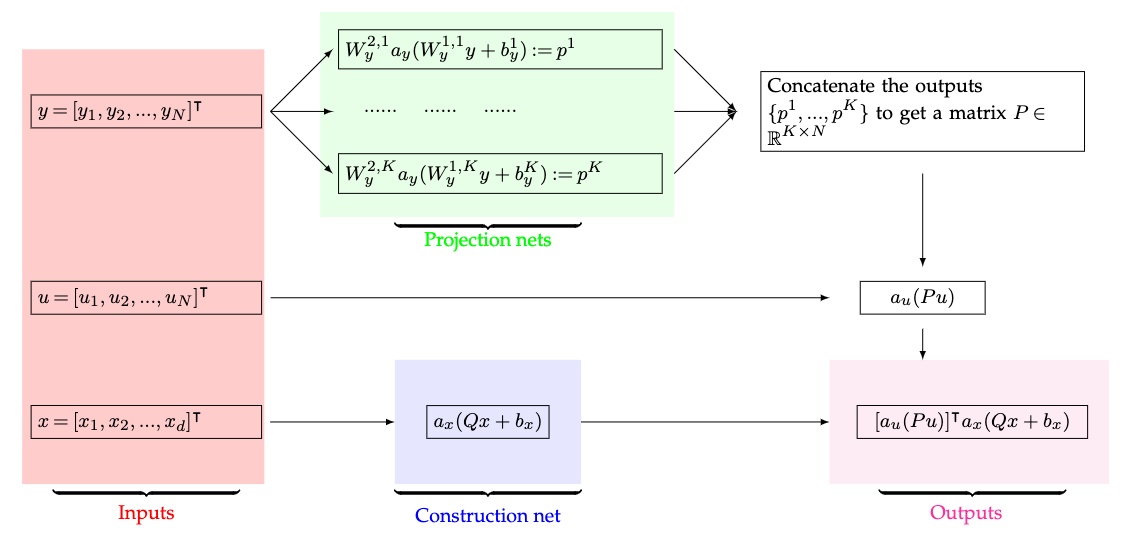

The next cell, OneProjectionNet, is one projection net (e.g.,$ W_y^{2, 1}a_y(W_y^{1,1}y+b_y^1)$) in the green area in the Figure above. 

It is a two-layer neural network. Even a very simple structure with a small number amount of trainable parameters of OneProjectionNet can give reliable result.

However, the Construction net usually should be deep.

Each OneProjectionNet outputs a vector which has the dimension = the number of sensors for each input function (IC).

In [9]:
activation1 = nn.Tanh()
class OneProjectionNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        bo_b = True
        bo_last = False

        self.l1 = nn.Linear(np.shape(set_of_testing_coord_of_source)[1], 100, bias = bo_b).to(device)        
        self.l4 = nn.Linear(100, np.shape(set_of_training_source_value)[1], bias = bo_last).to(device)
        
        
    def forward(self, v):
        v = activation1 ( self.l1(v) )
        v = ( self.l4(v) )       

        return v

AllProjectionNets combines all OneProjectionNets. It will assemble the $P$ matrix, which has dimension: number of basis ($K$) $\times $ number of sensors ($N$).

dim_output_space_basis, which is the $K$ in the Figure above, is one critical parameter. 

From the theory point of view, it represents the number of basis for the output function space. 

The relative error decays as dim_output_space_basis increases, however, it is stable when dim_output_space_basis is large enough.

The output of AllProjectionNets (projection nets) has dimension: number of samples, number of basis (dim_output_space_basis), number of sensors ($N$ in mathematical formulation above) for each input function.


In [10]:
class AllProjectionNets(nn.Module):
    def __init__(self):
        super().__init__()
        
        bo_b = True
        bo_last = False
        
        self.set_lay = []
        
        for jj in range(dim_output_space_basis):
            self.set_lay.append(OneProjectionNet())
        
        
    def forward(self, v):

        w = self.set_lay[0](v)

        for ii in range(dim_output_space_basis-1):
            w = torch.cat((w, self.set_lay[ii+1](v)), dim = 1 )
        
        # W dimension: number of samples, number of basis (dim_output_space_basis), number of sensors for each input function
        return w

Construction net learns the basis for the output function space. Our suggestion is to use a deeper network for the Construction net. 

Additionally, the activation functions selection in operator learning particularly DeepONet and BelNet are critical. The network predictions vary greatly given different activations.

In [11]:
activation2 = nn.Tanh()
class Construction(nn.Module):
    def __init__(self):
        super().__init__()
        
        bo_b = True
        bo_last = False

        self.l3 = nn.Linear(2, 100, bias = bo_b).to(device)
        self.l4 = nn.Linear(100, 100, bias = bo_b).to(device)
        self.l5 = nn.Linear(100, 100, bias = bo_b).to(device)
        self.l51 = nn.Linear(100, 100, bias = bo_b).to(device)
        self.l52 = nn.Linear(100, 100, bias = bo_b).to(device)
        self.l6 = nn.Linear(100, 100, bias = bo_b).to(device)
        self.l7 = nn.Linear(100, dim_output_space_basis, bias = bo_last).to(device)
        
        self.l8 = nn.Linear(2, dim_output_space_basis, bias = bo_b).to(device)
        
    def forward(self, w):
        w = activation2 ( self.l3(w) )
        w = activation2 ( self.l4(w) )
        w = activation2 ( self.l5(w) )
        w = activation2 ( self.l51(w) )
        w = activation2 ( self.l52(w) )
        w = activation2 ( self.l6(w) )
        w =  ( self.l7(w) )
        
        # dim of w: number of samples, 1, dim_output_space_basis
        # please note that, the 1 is an auxiliary dimension used for the later matrix multiplications.
        return w

The Test net is trainable and will introduce the nonlinearity.

The l7 linear layer and the activation function is a simplication (much less trainable parameters) of the theoretical BelNet network structure but works well.

In [12]:
activation3 = nn.ReLU()
class Test(nn.Module):
    def __init__(self):
        super().__init__()
        
        bo_b = True
        bo_last = False
        
        
        self.top = AllProjectionNets()
        self.bottom = Construction()
        
        self.l7 = nn.Linear(dim_output_space_basis, dim_output_space_basis, bias = bo_last).to(device)
        
    # v: projection net input, sensors of the input functions
    # w: construction net input, independent variable of the output function.
    # y: input function value evaluated at all sensors.
    def forward(self, v, w, y):
        v = self.top(v)
        w = self.bottom(w)
        
        
        # pu dimension: number of samples, dim_output_space_basis, 1
        pu = torch.bmm(v, y)
        
        
        # The next step introduces the nonlinearity (nonlinear in u, which is the input function)
        # This is a simplification of the BelNet designed based on the universal approximation theory.
        # This l7 layer has a very small number of trainable parameters.
        
        pu = activation3(self.l7(torch.squeeze(pu)))
        
        pu = torch.unsqueeze(pu, -1)
        e = torch.bmm(w , (pu) )

        return e[:, :, 0]

The next cell is the training step. 

We will train multiple modes independently and save the relative errors for all different trainings.

In [13]:
nb_training = 50
nb_epochs = 5000
lrG = 0.005

nb_of_testing_samples = len(set_of_testing_coord_of_source)

# save the relative errors of all independent training.
set_all_relative_err = []

for tt in range(nb_training):
    
    fnn_adam = Test()
    optimizerG = optim.Adam(fnn_adam.parameters(), lr = lrG )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizerG, step_size = 1000, gamma = 0.5)
    
    for ep in range(nb_epochs):

        output = fnn_adam(torch_training_node_input, torch_training_dependent_input, torch_training_u_input)
        diff = output - torch_training_output
        loss = torch.sqrt((diff*diff).mean() )

        fnn_adam.zero_grad()

        loss.backward()
        optimizerG.step()
        scheduler.step()
        
        
    # save relative error of all testing samples
    relative_err_all_testing_samples = []

    # calculate the mean relative error for all samples.
    for ii in (range(nb_of_testing_samples)):


        torch_testing_u_input, torch_testing_node_input, torch_testing_output, torch_testing_dependent_input = testing_in_output(ii, testing_x_index, False )

        pred_output = fnn_adam(torch_testing_node_input, torch_testing_dependent_input, torch_testing_u_input)
        pred_output = pred_output.cpu().detach().numpy()

        exact_sol = torch_testing_output.cpu().detach().numpy()

        err = pred_output - exact_sol
        relative_err = LA.norm(err)/LA.norm(exact_sol)*100
        relative_err_all_testing_samples.append(relative_err)
    
    print(tt,  "mean", np.round(np.mean(relative_err_all_testing_samples), 6) )
    
    set_all_relative_err.append(relative_err_all_testing_samples)
    
    
        

0 mean 1.290084
1 mean 1.074648
2 mean 1.522842
3 mean 1.415201
4 mean 1.384664
5 mean 1.067385
6 mean 2.08214
7 mean 1.421756
8 mean 1.35487
9 mean 2.048747
10 mean 1.028864
11 mean 1.981276
12 mean 1.412156
13 mean 1.008117
14 mean 1.327269
15 mean 1.748391
16 mean 1.42366
17 mean 1.425034
18 mean 1.340351
19 mean 1.539495
20 mean 1.521902
21 mean 1.163269
22 mean 1.387284
23 mean 1.071565
24 mean 1.191776
25 mean 1.369629
26 mean 1.329189
27 mean 1.550232
28 mean 1.381597
29 mean 2.743529
30 mean 1.708539
31 mean 1.758739
32 mean 1.026431
33 mean 2.720071
34 mean 1.742548
35 mean 1.364183
36 mean 1.655734
37 mean 1.940428
38 mean 1.489285
39 mean 2.597841
40 mean 1.579112
41 mean 0.90346
42 mean 1.324247
43 mean 1.391286
44 mean 1.518267
45 mean 1.197286
46 mean 1.522001
47 mean 1.333854
48 mean 1.558956
49 mean 1.676892


In [14]:
set_all_relative_err = np.array(set_all_relative_err)
print("set_all_relative_err", np.shape(set_all_relative_err))
print("relative errors of all training", np.mean(np.mean(set_all_relative_err, axis = 1) ) )

# remove the worst 100 predictions (closed to 5% of the total testing samples) 
remove_outliers = []
for ii in range(len(set_all_relative_err)):
    remove_outliers.append(np.sort(set_all_relative_err[ii])[:-100])
    
print("remove_outliers", np.shape(remove_outliers))
print("mean relative errors of all training (remove outliers)", np.mean(np.mean(remove_outliers, axis = 1) ) )

# remove the worst 5 trainings
print("np.mean(set_all_relative_err, axis = 1)", np.shape(np.mean(set_all_relative_err, axis = 1) ) )
print("Mean relative error (remove 5 worst training results)", np.mean(np.sort(np.mean(set_all_relative_err, axis = 1))[:-5]))
    

set_all_relative_err (50, 1801)
relative errors of all training 1.5123216309212355
remove_outliers (50, 1701)
mean relative errors of all training (remove outliers) 1.422574785357064
np.mean(set_all_relative_err, axis = 1) (50,)
Mean relative error (remove 5 worst training results) 1.4094167498468795


In [15]:
np.save("set_all_relative_err", set_all_relative_err)